## Introduction to ARCH and GARCH Models

The **ARCH (Autoregressive Conditional Heteroskedasticity)** model was introduced by Robert Engle in 1982, providing a way to model financial time series data where volatility changes over time. The ARCH model can be specified as follows:

$$
\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \ldots + \alpha_q \epsilon_{t-q}^2
$$

where:
- $\sigma_t^2$ is the conditional variance,
- $\epsilon_{t-k}$ are the residuals from a mean equation at time $t-k$,
- $\alpha_0, \alpha_1, \ldots, \alpha_q$ are parameters to be estimated.

The **GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** model, introduced by Tim Bollerslev in 1986, extends the ARCH model by including past conditional variances:

$$
\sigma_t^2 = \alpha_0 + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2
$$

where:
- $p$ is the number of lagged variance terms,
- $q$ is the number of lagged squared residuals,
- $\beta_j$ are parameters for the past variances.

These models are widely used in finance and economics to model the volatility (variance of returns) of financial time series.


### install related packages

In [1]:
!pip install arch

  Obtaining dependency information for arch from https://files.pythonhosted.org/packages/3e/5b/d6ef1ce2a6a6ace0184234b0f2bfdc754980814fba4802ccf9415d746579/arch-7.0.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.2/956.2 kB 6.5 MB/s eta 0:00:0000:0100:01


In [5]:
import pandas as pd
import numpy as np
from arch import arch_model

data_path = '../data/cleaned_data/btc_1d_with_volatilities.csv'
btc_df = pd.read_csv(data_path, parse_dates=['date'], index_col=0)# Assuming 'data' is a DataFrame containing Bitcoin prices with a 'Close' column
btc_df['returns'] = btc_df['close'].pct_change() * 100
btc_df.dropna(inplace=True)  # Removing NaN values that occur from pct_change()


features_path = '../data/cleaned_data/btc_1d_engineered_selected_features.csv'
features_df = pd.read_csv(features_path, parse_dates=['date'], index_col=0)

### Use the pre-engineered features by Frank

In [28]:
features_df['return'] = features_df['close'].pct_change() * 100
features_df.dropna(inplace=True)  # Removing NaN values that occur from pct_change()

features_df

,close,Volume BTC,Volume USD,5_day_vol,rsi_14_over_30,rsi_7_over_14,vol_ratio_30_over_150,7_day_vol,target,returns,return
date,,,,,,,,,,,
2016-03-07,412.04,2426.501107,4.128400e+04,0.026930,0.640948,0.771759,0.568524,0.023761,0.023934,2.625156,2.625156
2016-03-08,412.09,1368.555389,2.343026e+04,0.026990,0.779819,0.688480,0.568466,0.023934,0.022044,0.012135,0.012135
2016-03-09,411.00,3401.546586,5.813963e+04,0.023666,0.707895,0.923819,0.564374,0.022044,0.022505,-0.264505,-0.264505
2016-03-10,414.71,1747.137702,3.002391e+04,0.012316,0.739002,1.017529,0.565154,0.022505,0.019709,0.902676,0.902676
2016-03-11,418.94,1605.472096,2.803512e+04,0.011321,0.721638,1.469526,0.560276,0.019709,0.015935,1.019990,1.019990
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06,22441.68,235.652360,2.204278e+05,0.017886,0.488703,1.186195,1.015165,0.019501,0.019186,0.059478,0.059478
2023-03-07,22211.93,440.863300,4.085653e+05,0.017833,0.500007,1.215775,1.010486,0.019186,0.015354,-1.023765,-1.023765
2023-03-08,21704.40,397.794102,3.653873e+05,0.010364,0.485093,0.193158,1.017991,0.015354,0.024971,-2.284943,-2.284943


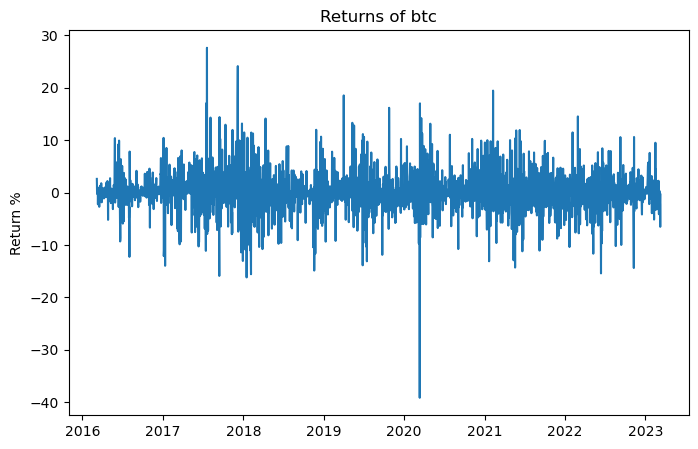

In [47]:
# Add trace plot
plt.figure(figsize=(8,5))
plt.plot(features_df['return'])
plt.ylabel("Return %")
plt.title('Returns of btc');

### Check the ACF and PACF of btc returns

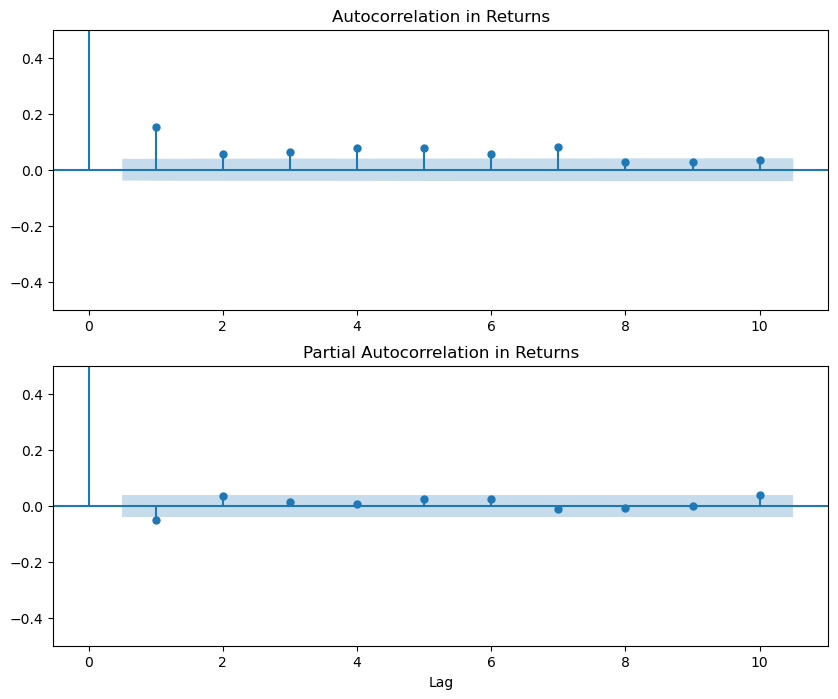

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
returns = features_df['return'].iloc[1:]

abs_r = returns ** 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_r, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5) 
ax1.set_title("Autocorrelation in Returns")
plot_pacf(diff_ts, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)  
ax2.set_xlabel("Lag")  
ax2.set_title("Partial Autocorrelation in Returns")

plt.show()

### Split the data into 80% and 20% as training and testing set

In [29]:
# Calculate the split index
split_idx = int(len(features_df) * 0.8)

# Split the data
train = features_df.iloc[:split_idx]
test = features_df.iloc[split_idx:]
train

,close,Volume BTC,Volume USD,5_day_vol,rsi_14_over_30,rsi_7_over_14,vol_ratio_30_over_150,7_day_vol,target,returns,return
date,,,,,,,,,,,
2016-03-07,412.04,2426.501107,4.128400e+04,0.026930,0.640948,0.771759,0.568524,0.023761,0.023934,2.625156,2.625156
2016-03-08,412.09,1368.555389,2.343026e+04,0.026990,0.779819,0.688480,0.568466,0.023934,0.022044,0.012135,0.012135
2016-03-09,411.00,3401.546586,5.813963e+04,0.023666,0.707895,0.923819,0.564374,0.022044,0.022505,-0.264505,-0.264505
2016-03-10,414.71,1747.137702,3.002391e+04,0.012316,0.739002,1.017529,0.565154,0.022505,0.019709,0.902676,0.902676
2016-03-11,418.94,1605.472096,2.803512e+04,0.011321,0.721638,1.469526,0.560276,0.019709,0.015935,1.019990,1.019990
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-10,54704.74,1090.004557,2.507386e+06,0.038076,1.268439,1.049855,0.914126,0.033567,0.035778,-0.479802,-0.479802
2021-10-11,57500.00,1028.194272,2.431425e+06,0.029331,1.325411,1.003247,0.928323,0.035778,0.038193,5.109722,5.109722
2021-10-12,56019.08,1812.111067,4.249397e+06,0.028739,1.364379,0.844673,0.943890,0.038193,0.028302,-2.575513,-2.575513


In [58]:
# Define the GARCH model on training data
model = arch_model(train['return'], mean='Zero', vol='Garch', p=1, q=1)

# Fit the model
model_fit = model.fit(disp='off')
print(model_fit.summary())


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5629.88
Distribution:                  Normal   AIC:                           11265.8
Method:            Maximum Likelihood   BIC:                           11282.6
                                        No. Observations:                 2048
Date:                Mon, Apr 29 2024   Df Residuals:                     2048
Time:                        22:05:54   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.6356      0.287      2.213  2.686e-02 [7.280e-0

### Evalute the model on test set

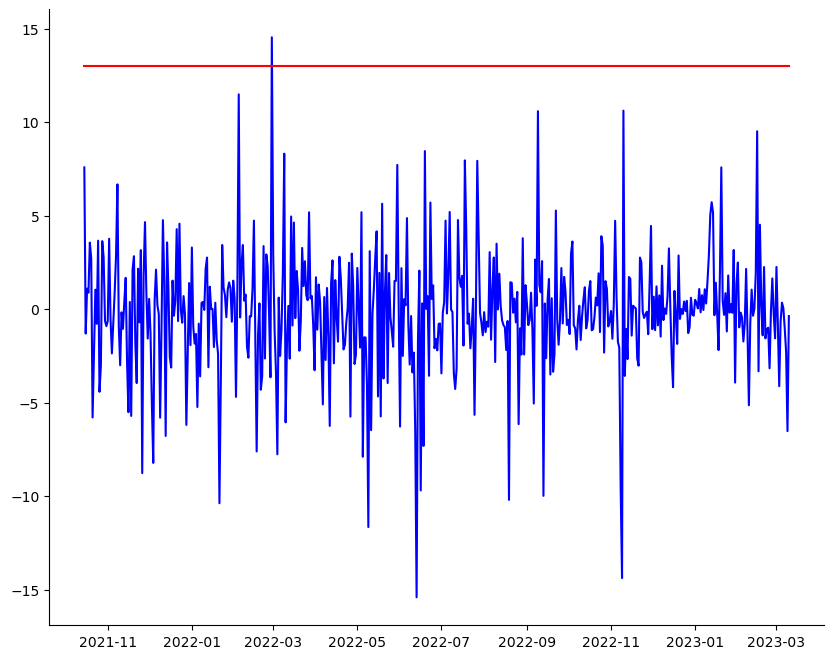

In [67]:
forecast_vol = model_fit.forecast(horizon = 1)

fig, ax = plt.subplots(figsize=(10,8))
ax.spines[['top','right']].set_visible(False)
# Plot test set returns

plt.plot(test.index, test['return'], label='Actual Returns', color='blue')
arr_pre = np.full(len(test), forecast_vol.variance.values[-1, :], dtype=int)
plt.plot(test.index, arr_pre, label='Forecasted Volatility', color='red')

In [83]:
test['7_day_vol'] = test['7_day_vol'].apply(lambda x: x*100.0)
test

/var/folders/r4/2__jqg613_ggf0f1z8vmptrw0000gn/T/ipykernel_89605/24718773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['7_day_vol'] = test['7_day_vol'].apply(lambda x: x*100.0)


,close,Volume BTC,Volume USD,5_day_vol,rsi_14_over_30,rsi_7_over_14,vol_ratio_30_over_150,7_day_vol,target,returns,return
date,,,,,,,,,,,
2021-10-15,61665.41,3228.284994,8.177624e+06,0.040381,1.270718,1.026245,0.962057,3.477856,0.036935,7.582843,7.582843
2021-10-16,60864.75,927.322123,2.365091e+06,0.040148,1.263382,0.948193,1.002296,3.693496,0.035976,-1.298394,-1.298394
2021-10-17,61536.09,806.297013,2.032537e+06,0.034451,1.242403,0.985687,1.018176,3.597645,0.032803,1.103003,1.103003
2021-10-18,62080.22,2631.758795,6.774344e+06,0.034595,1.242949,0.929222,1.031110,3.280325,0.029205,0.884245,0.884245
2021-10-19,64291.80,1987.016133,5.226203e+06,0.033862,1.186089,1.137428,1.025243,2.920483,0.029292,3.562455,3.562455
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06,22441.68,235.652360,2.204278e+05,0.017886,0.488703,1.186195,1.015165,1.950142,0.019186,0.059478,0.059478
2023-03-07,22211.93,440.863300,4.085653e+05,0.017833,0.500007,1.215775,1.010486,1.918601,0.015354,-1.023765,-1.023765
2023-03-08,21704.40,397.794102,3.653873e+05,0.010364,0.485093,0.193158,1.017991,1.535382,0.024971,-2.284943,-2.284943


/var/folders/r4/2__jqg613_ggf0f1z8vmptrw0000gn/T/ipykernel_89605/1192558489.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['actual_vol_change'] = test['7_day_vol'].diff()
/var/folders/r4/2__jqg613_ggf0f1z8vmptrw0000gn/T/ipykernel_89605/1192558489.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_vol_change'] = predicted_vol_series.diff()
/var/folders/r4/2__jqg613_ggf0f1z8vmptrw0000gn/T/ipykernel_89605/1192558489.py:36: SettingWithCopyWarning: 
A value is trying to be set on a c

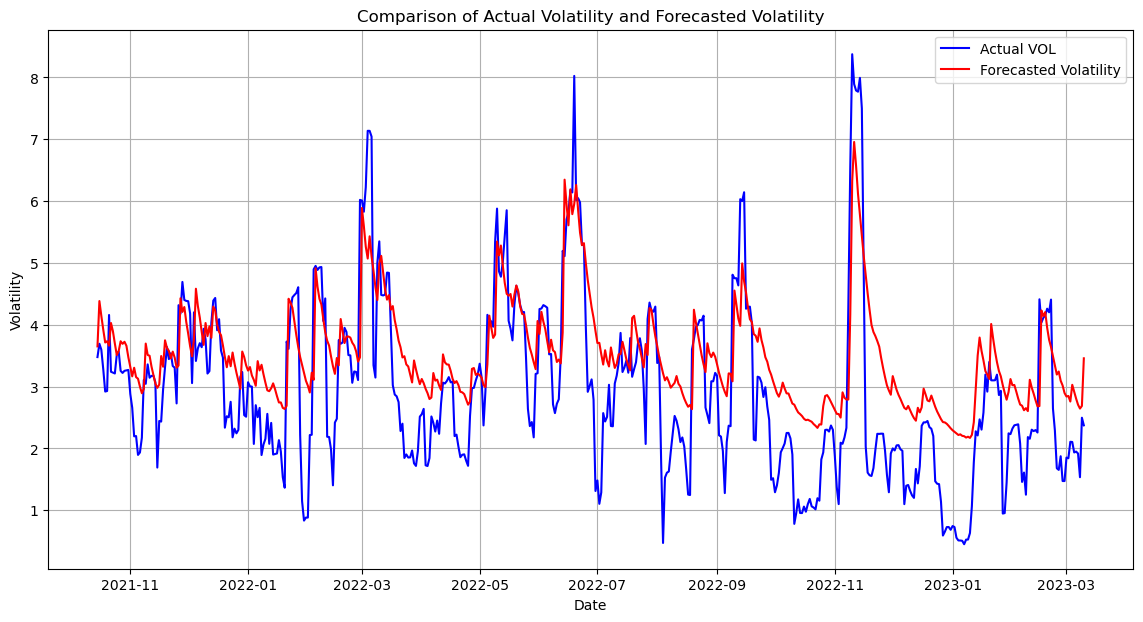

Root Mean Squared Error (RMSE): 1.0262347950555812
Mean Absolute Error (MAE): 0.8372169934875193
Theil's U Statistic: 0.15013221261604484
Hit Rate: 0.5234375


In [87]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicted_variance = []
for i in range(len(test)):
    # Update the model with one more step
    temp_data = pd.concat([train, test.iloc[:i]])
    model = arch_model(temp_data['return'], mean='Zero', vol='Garch', p=1, q=1)
    res = model.fit(disp='off', last_obs=len(train) + i)

    # Forecast the next day variance
    temp_forecast = res.forecast(horizon=1)
    predicted_variance.append(temp_forecast.variance.values[-1, -1])

predicted_volatility = np.sqrt(predicted_variance)  # Taking the square root to get the volatility

# Assumed that predicted_volatility and test['return'] are already defined and available

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['7_day_vol'], predicted_volatility))

# Calculate MAE
mae = mean_absolute_error(test['7_day_vol'], predicted_volatility)

# Calculate Theil's U Statistic
numerator = np.sqrt(np.sum((test['7_day_vol'] - predicted_volatility) ** 2))
denominator = (np.sqrt(np.sum(test['7_day_vol'] ** 2)) + np.sqrt(np.sum(predicted_volatility ** 2)))
theils_u = numerator / denominator

# Calculate Hit Rate
# Assuming that a "hit" is defined as both the forecasted and actual values having the same sign
test['actual_vol_change'] = test['7_day_vol'].diff()
predicted_vol_series = pd.Series(predicted_volatility, index=test.index)
test['predicted_vol_change'] = predicted_vol_series.diff()
test['hit'] = np.sign(test['actual_vol_change']) == np.sign(test['predicted_vol_change'])
hit_rate = test['hit'].mean()

# Plotting the comparison
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['7_day_vol'], label='Actual VOL', color='blue')
plt.plot(test.index, predicted_volatility, label='Forecasted Volatility', color='red')
plt.title('Comparison of Actual Volatility and Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Theil's U Statistic:", theils_u)
print("Hit Rate:", hit_rate)


### try hyper parameter tuning

In [74]:
from arch import arch_model

# Assuming 'returns' is your series of interest
best_aic = np.inf
best_p = 0
best_q = 0
best_model = None

for p in range(1, 8):  # Test p from 1 to 7
    for q in range(1, 8):  # Test q from 1 to 7
        model = arch_model(train['return'], p=p, q=q)
        res = model.fit(disp='off')
        if res.aic < best_aic:
            best_aic = res.aic
            best_p = p
            best_q = q
            best_model = res

print(f'Best model (p, q): ({best_p}, {best_q}) with AIC: {best_aic}')


Best model (p, q): (4, 1) with AIC: 11223.724395769288


### train new model with p = 4 q = 1

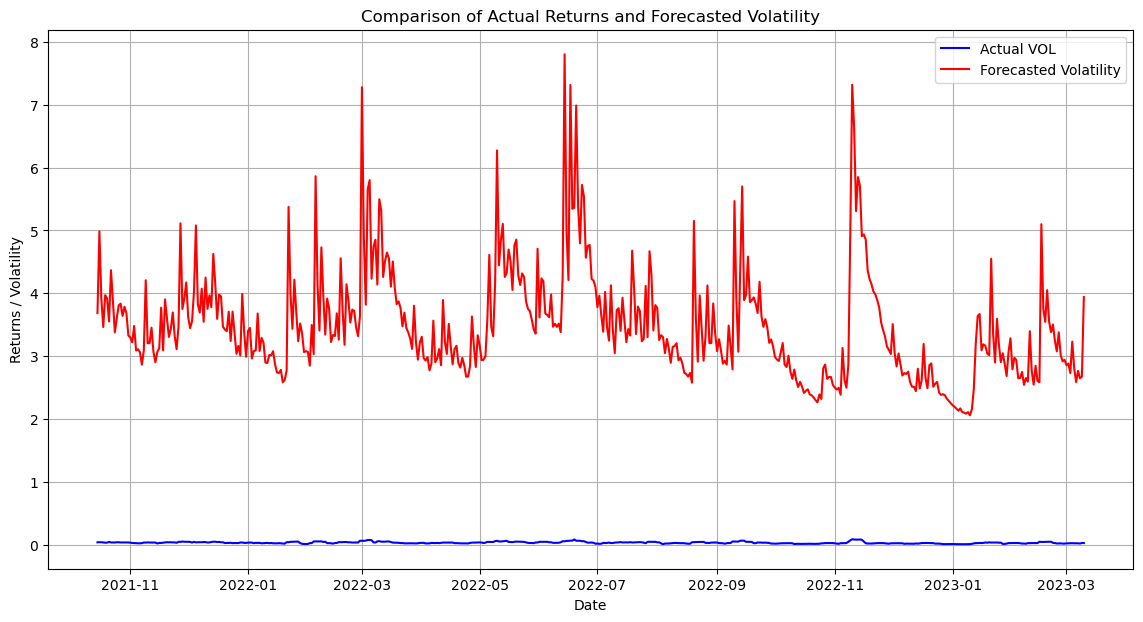

Root Mean Squared Error (RMSE): 3.5634086706337533
Mean Absolute Error (MAE): 3.460973470709834
Theil's U Statistic: 0.9825266786047676
Hit Rate: 1.0


In [72]:
predicted_variance = []
for i in range(len(test)):
    # Update the model with one more step
    temp_data = pd.concat([train, test.iloc[:i]])
    model = arch_model(temp_data['return'], mean='Zero', vol='Garch', p=4, q=1)
    res = model.fit(disp='off', last_obs=len(train) + i)

    # Forecast the next day variance
    temp_forecast = res.forecast(horizon=1)
    predicted_variance.append(temp_forecast.variance.values[-1, -1])

predicted_volatility = np.sqrt(predicted_variance)  # Taking the square root to get the volatility

# Assumed that predicted_volatility and test['return'] are already defined and available

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['7_day_vol'], predicted_volatility))

# Calculate MAE
mae = mean_absolute_error(test['7_day_vol'], predicted_volatility)

# Calculate Theil's U Statistic
numerator = np.sqrt(np.sum((test['7_day_vol'] - predicted_volatility) ** 2))
denominator = (np.sqrt(np.sum(test['7_day_vol'] ** 2)) + np.sqrt(np.sum(predicted_volatility ** 2)))
theils_u = numerator / denominator

# Calculate Hit Rate
# Assuming that a "hit" is defined as both the forecasted and actual values having the same sign
test['actual_vol_change'] = test['7_day_vol'].diff()
predicted_vol_series = pd.Series(predicted_volatility, index=test.index)
test['predicted_vol_change'] = predicted_vol_series.diff()
test['hit'] = np.sign(test['actual_vol_change']) == np.sign(test['predicted_vol_change'])
hit_rate = test['hit'].mean()

# Plotting the comparison
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['7_day_vol'], label='Actual VOL', color='blue')
plt.plot(test.index, predicted_volatility, label='Forecasted Volatility', color='red')
plt.title('Comparison of Actual Volatility and Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Theil's U Statistic:", theils_u)
print("Hit Rate:", hit_rate)
